In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import trange, tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from data.dataloader import *

# sns.set(style='ticks', context='talk')
plt.style.use('seaborn-poster')
plt.style.use("paper.mplstyle")
np.random.seed(20201009)

# Data

In [2]:
def get_data(dataset, showcase=True, **kwargs):
    age_df = load_age_sample_from_mcmc_chains(dataset, **kwargs)
    hr_df = load_hr()
    age_df, hr_df = clean_data(age_df, hr_df)
    snids = age_df.index.unique().tolist()

    if showcase:
        display(hr_df.join(age_df["age"].groupby('snid').agg([list, len, np.mean, np.std]).add_prefix("age_")))

        # Joint plot of Age and HR row means
        sns.jointplot(x=age_df.groupby('snid').mean()['age'], y=hr_df['hr'], s=30).plot_joint(sns.kdeplot, zorder=0, n_levels=4)
        plt.xlabel("Age Posterior Sample Mean [Gyr]")
        plt.ylabel("Hubble Residual [mag]")
        plt.show()
        
    return snids, age_df, hr_df

## Campbell HR and Local Age

Hubble residual and local environment  age derived from the C13 dataset 

[C13]: Campbell, H., D’Andrea, C. B., Nichol, R. C., et al. 2013, ApJ, 763, 88

Missing from R19 Table 1 of SNID: {15459}
Missing from Campbell MCMC chains of SNID: {3256}
Resulting data will be an inner join of the two remove all SNID mentioned above


,hr,hr_err,age_list,age_len,age_mean,age_std
snid,,,,,,
762,0.15,0.08,"[5.105650637218932, 5.426390857309904, 8.23127...",50000.0,5.114123,2.392041
1032,-0.15,0.12,"[3.9733716483842656, 5.060704469395271, 2.5937...",50000.0,5.587337,2.364265
1371,-0.14,0.06,"[9.629968548258693, 9.007912196190736, 2.03108...",50000.0,7.193960,3.647477
1794,0.27,0.08,"[3.8316252692185375, 3.270402400923352, 2.5575...",50000.0,3.918969,1.371659
2372,-0.12,0.07,"[5.877710566551527, 6.8792269025281785, 5.6551...",50000.0,5.912454,1.674225
...,...,...,...,...,...,...
20764,-0.18,0.09,"[7.52283576695097, 9.145380579842763, 10.94632...",50000.0,8.746359,2.471066
21034,0.08,0.06,"[2.3711713875966995, 2.5675612947821245, 1.732...",50000.0,3.352937,1.093974
21487,-0.30,0.08,"[1.7054287233516017, 4.815469121716643, 2.7463...",50000.0,5.190174,0.998331


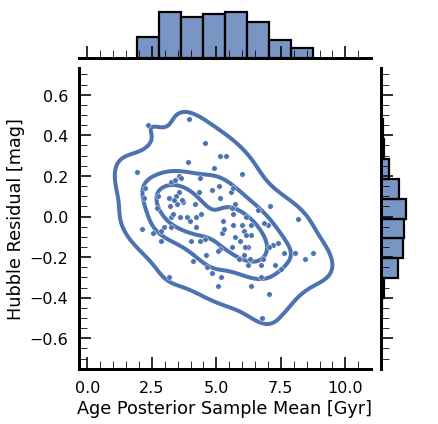

In [3]:
snids, age_df, hr_df = get_data("campbell")

## Campbell HR and Global Age

Hubble residual derived from the C13 dataset and global environment age dervied from SDSS-DR12.

* [C13]: Campbell, H., D’Andrea, C. B., Nichol, R. C., et al. 2013, ApJ, 763, 88
* [SDSS]: Sako, M., Bassett, B., Becker, A., et al. 2008, AJ, 135, 348

Missing from R19 Table 1 of SNID: {15459}
Missing from Campbell MCMC chains of SNID: {3256}
Resulting data will be an inner join of the two remove all SNID mentioned above


,hr,hr_err,age_list,age_len,age_mean,age_std
snid,,,,,,
762,0.15,0.08,"[1.8998283546816948, 9.612087490681036, 8.9747...",50000.0,6.583601,3.230324
1032,-0.15,0.12,"[2.059654138374184, 10.315881502016566, 10.481...",50000.0,6.953366,3.610085
1371,-0.14,0.06,"[5.111284937010133, 8.23058605373879, 7.692049...",50000.0,7.946220,1.394925
1794,0.27,0.08,"[1.6493880086259436, 0.9064396037799802, 2.827...",50000.0,2.139138,0.920541
2372,-0.12,0.07,"[10.370770743548526, 3.747848840535165, 5.6189...",50000.0,4.863370,2.534560
...,...,...,...,...,...,...
20764,-0.18,0.09,"[6.629658454603227, 5.338804142115605, 5.91686...",50000.0,5.506002,1.700633
21034,0.08,0.06,"[4.611434345890299, 5.597659268372222, 6.81482...",50000.0,5.772749,0.625523
21487,-0.30,0.08,"[5.771450015963848, 5.1997705126466505, 5.3203...",50000.0,5.733963,1.278805


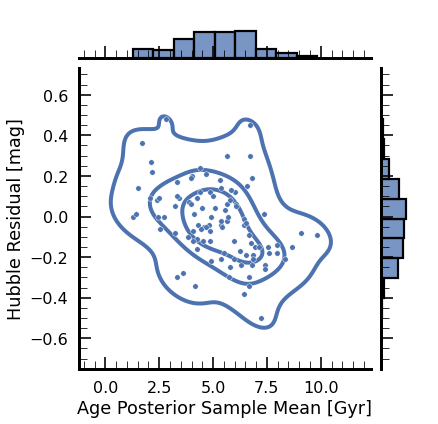

In [4]:
snids_global, age_global_df, hr_global_df = get_data("campbellG")

# Slope Analysis

In [5]:
from corner import corner

def plot_slope_analysis(name="local", burn=0):
    # DATA
    labels = ["intercept", "slope", "scatter"]
    results = {}
    for path in Path("results/pymc3/").glob(f"*_{name}.npz"):
        npz = np.load(path)
        results[path.stem.replace(f"_{name}", "")] = npz["arr_0"]
       
    # CORNER PLOT
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(wspace=0, hspace=0)

    corner(np.vstack([results[label].flatten()[burn:] for label in labels]).T, 
           labels=labels, 
           show_titles=True,
           color='k',
           title_fmt='.3f', 
           title_kwargs={"fontsize": 16*1.1},
           lw=2,
           quantiles=stats.norm.cdf([-1, 0, 1]), fig=fig
    )
    plt.savefig(f"paper/figures/pymc3_corner_{name}.png", dpi=300)
    
    # TRACE PLOT
    fig, axes = plt.subplots(3, 1, figsize=(24, 4*3), sharex=True)
    fig.subplots_adjust(hspace=0)
    
    for i, label in enumerate(labels):
        ax = axes[i]
        for j in range(results[label].shape[0]):
            ax.plot(results[label][j, :], color='k', lw=0.5, alpha=0.5)

        ax.axvline(burn, c='#c44e52', label=f"Burn-in period ({burn})")
        
        ax.yaxis.get_major_ticks()[-1].label1.set_visible(False)
        ax.set_xlim(-1, results[label].shape[1])
        ax.set_ylabel(label)
        ax.set_xlabel("Iteration")
        if i == 0: ax.legend()
            
    # REGRESSION PLOT
    
    # SUMMARY STATISTICS
    summary = {}
    for i, label in enumerate(labels):
        summary[label] = (f"{results[label].flatten()[burn:].mean():.2g} \pm {results[label].flatten()[burn:].std():.2g}")
        
    display(pd.DataFrame([summary]))

,intercept,slope,scatter
0,0.22 \pm 0.022,-0.049 \pm 0.0043,1.6 \pm 1.2


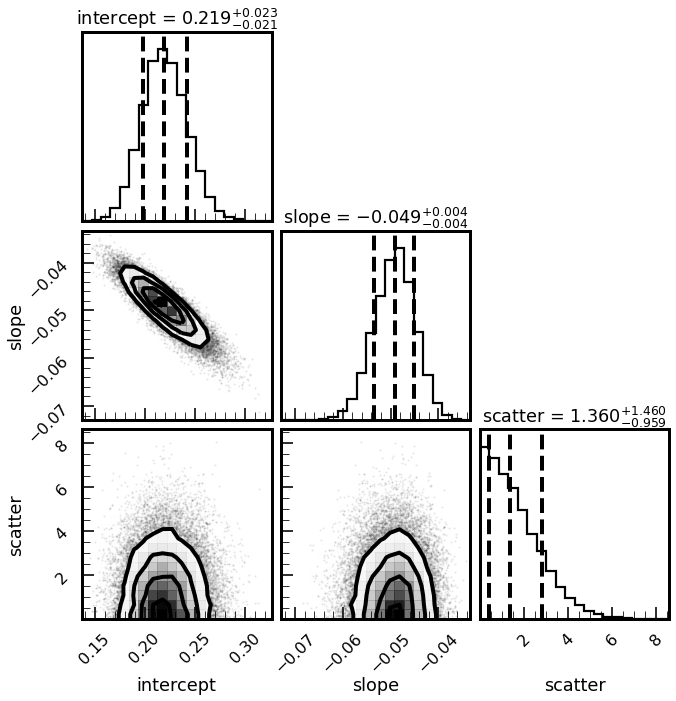

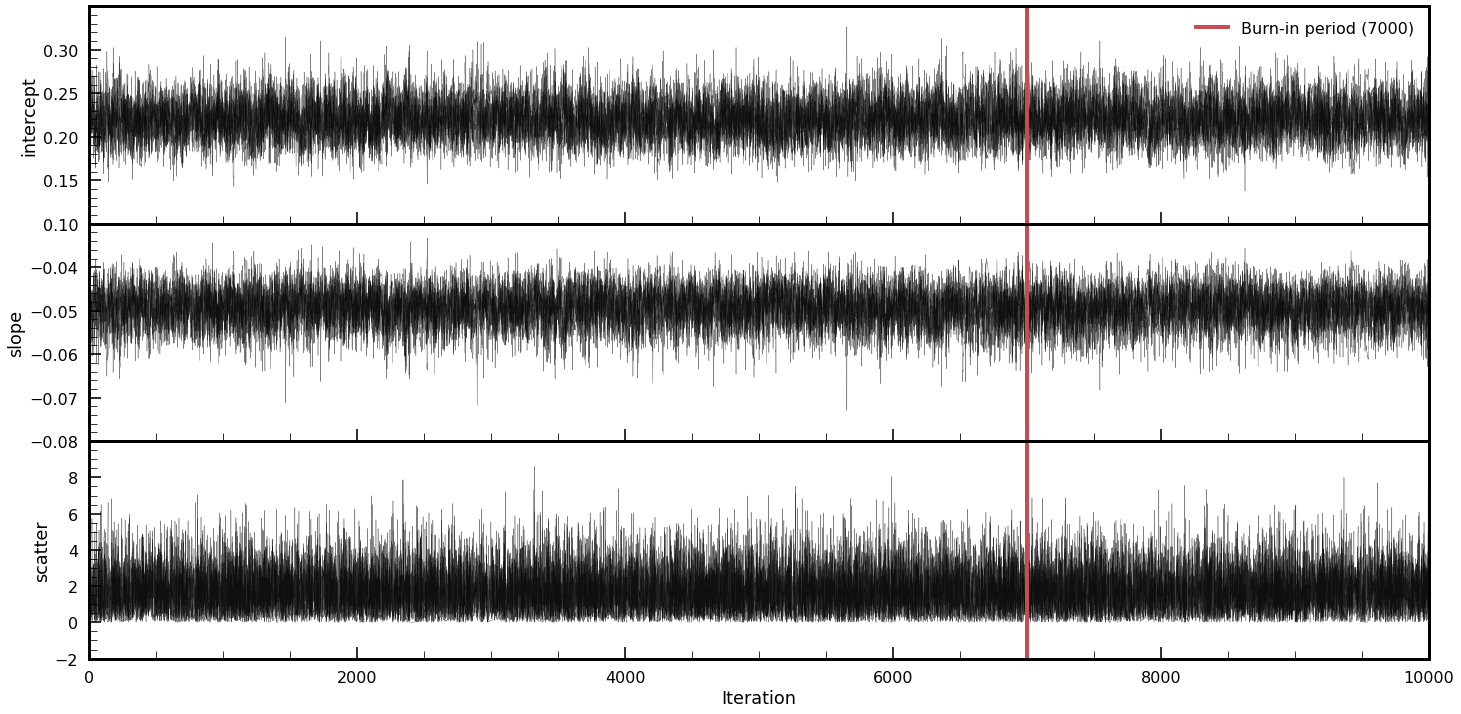

In [9]:
plot_slope_analysis(name="local", burn=7000)

,intercept,slope,scatter
0,0.23 \pm 0.022,-0.049 \pm 0.0038,1.6 \pm 1.2


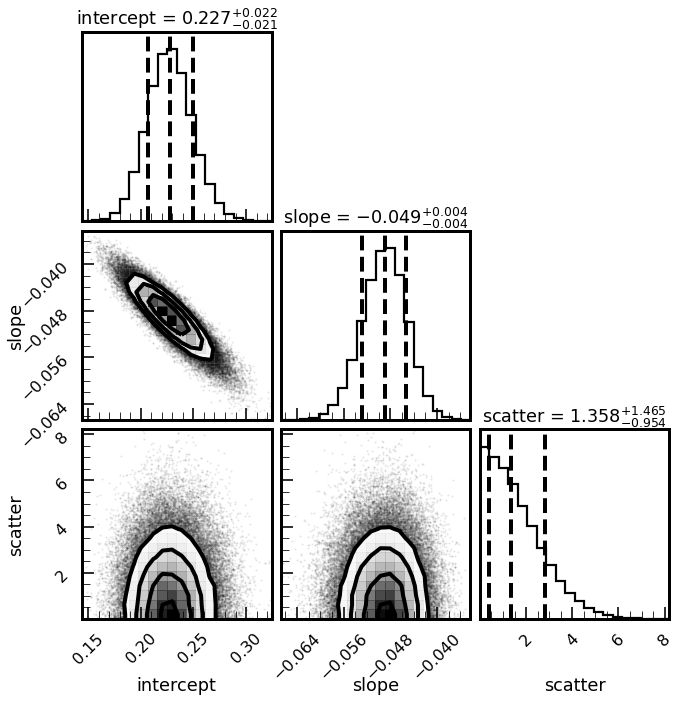

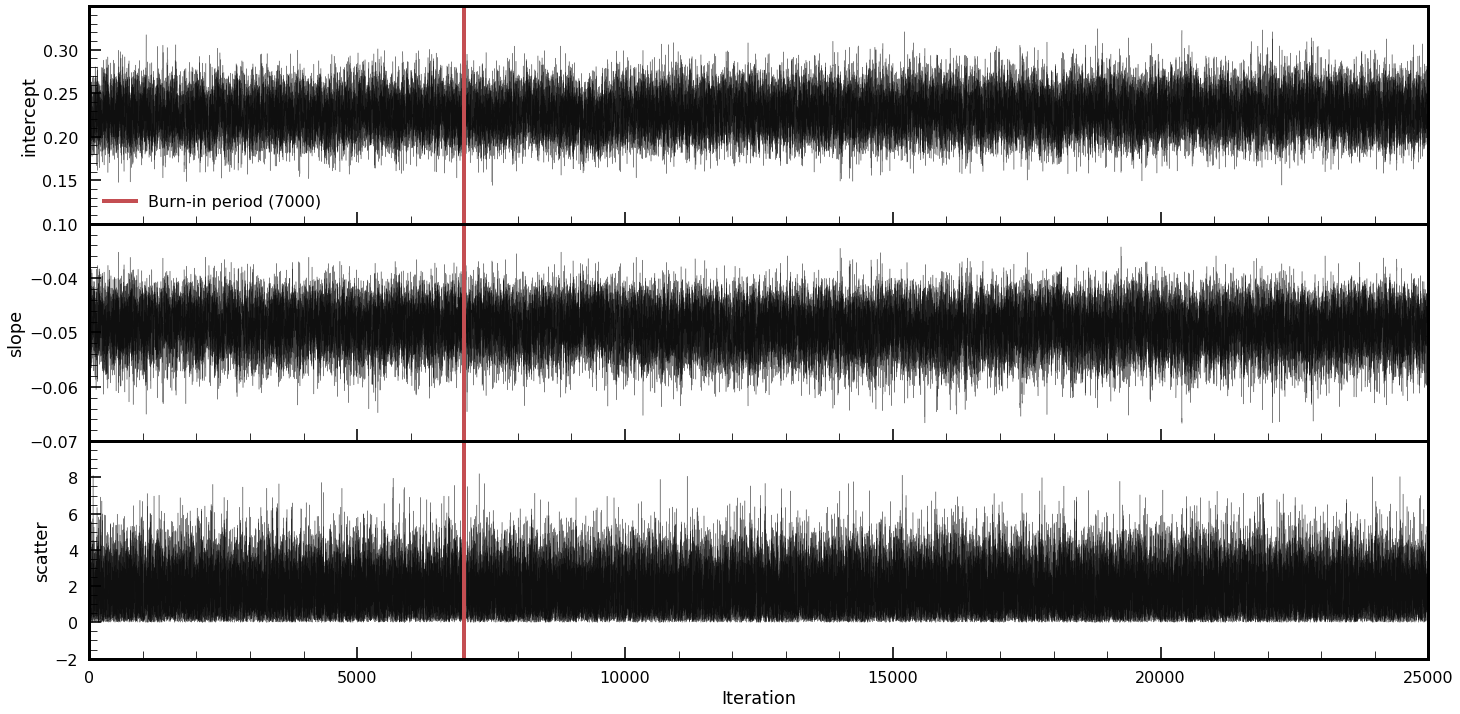

In [7]:
plot_slope_analysis(name="global", burn=7000)

# Correlation Analysis

* The biggest argument between Rose19 (or Rose20) and Lee20 is whether there is a correlation between HR and Age.
* Possible conclusions are:

    1. not enough data points
    2. there is no correlation
    3. there is a significant correlation, but it is not strong enough to deny dark energy
    4. there is a significant correlation, but slope is not large enough to deny dark energy
    5. there is a significant correlation, and slope is large enough to deny dark energy


notes:
* Lee20 claims number of samples causes 'dilution problem': how can we say this claim is not on point?
* Lee20 claims 'proper method' yields a large slope. If there are correlations, what is the slope?

In [7]:
from models.correlation import estimate_correlation

def plot_correlation_analysis(age_df, hr_df):
    # DATA
    results = []
    for i in trange(100):
        random_snids = np.random.choice(snids, size=len(snids), replace=True)
        result = estimate_correlation(age_df.groupby('snid').agg(['mean', 'var'])['age'].loc[random_snids, :], hr_df.loc[random_snids, :])
        results.append(result)

    results = np.array(results).reshape(100, 2)
    
    # PLOT
    sample_values = estimate_correlation(age_df.groupby('snid').agg(['mean', 'var'])['age'], hr_df)
    bins = np.arange(-0.5, 0, 0.5/20)

    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
    fig.subplots_adjust(wspace=0)

    ax = axs[0]
    ax.hist(results[:,0], bins, histtype="step", color='k', label=f"Bootstrap (${np.mean(results, axis=0)[0]:.2g}\pm{np.std(results, axis=0)[0]:.2g}$)")
    ax.axvline(sample_values[0], ls='--', label=f"Empirical (${sample_values[0]:.2g}$)")
    ax.set_title(f"Biased sample correlation")
    ax.legend()

    ax.set_ylabel("Count")
    ax.xaxis.get_major_ticks()[-1].label1.set_visible(False)


    ax = axs[1]
    ax.hist(results[:,1], bins, histtype="step", color='k',label=f"Bootstrap (${np.mean(results, axis=0)[1]:.2g}\pm{np.std(results, axis=0)[1]:.2g}$)")
    ax.axvline(sample_values[1], ls='--', label=f"Empirical (${sample_values[1]:.2g})$")
    ax.set_title(f"Corrected sample correlation")
    ax.legend()

    fig.add_subplot(111, frameon=False)
    plt.tick_params(which="both", labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Correlation")

    plt.savefig("paper/figures/correlation_estimation.pdf", bbox_inches='tight')
    
    
def plot_correlation_significance(age_df, hr_df):
    results = []
    for i in trange(300):
        random_age = age_df.groupby('snid').agg(['mean', 'var'])['age'].sample(frac=1, axis=0)
        random_hr_df = hr_df.sample(frac=1, axis=0)
        result = estimate_correlation(random_age, random_hr_df)
        results.append(result)

    results = np.array(results).reshape(300, 2)
    
    def get_discrepancy(sample_value, result_mean, result_std):
        return np.abs(sample_value - result_mean) / np.sqrt(0.047**2 + result_std**2)

    def get_pvalue(sample_value, bootstrap_sample):
        return np.mean(sample_values[1] > np.abs(results[:,1]))

    sample_values = estimate_correlation(age_df.groupby('snid').agg(['mean', 'var'])['age'], hr_df)
    bins = np.linspace(-0.4, 0.6, 30)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
    fig.subplots_adjust(wspace=0)
    
    ax = axs[0]
    ax.hist(results[:,0], bins, histtype="step", color='k', label=f"Bootstrap null hypothesis\n(${np.mean(results, axis=0)[1]:.2g}\pm{np.std(results, axis=0)[1]:.2g}$)")
    ax.axvline(sample_values[0], ls='--', label=f"Empirical\n({sample_values[0]:.2g}, p={get_pvalue(sample_values[0], results[:,0])}, ${get_discrepancy(sample_values[0], np.mean(results, axis=0)[0], np.std(results, axis=0)[0]):.2g}\sigma$)")
    ax.set_title(f"Bias sample correlation")
    ax.legend()

    ax = axs[1]
    ax.hist(results[:,1], bins, histtype="step", color='k', label=f"Bootstrap null hypothesis\n(${np.mean(results, axis=0)[1]:.2g}\pm{np.std(results, axis=0)[1]:.2g}$)")
    ax.axvline(sample_values[1], ls='--', label=f"Empirical\n({sample_values[1]:.2g}, p={get_pvalue(sample_values[1], results[:,1])}, ${get_discrepancy(sample_values[1], np.mean(results, axis=0)[1], np.std(results, axis=0)[1]):.2g}\sigma$)")
    ax.set_title(f"Corrected sample correlation")
    ax.legend()

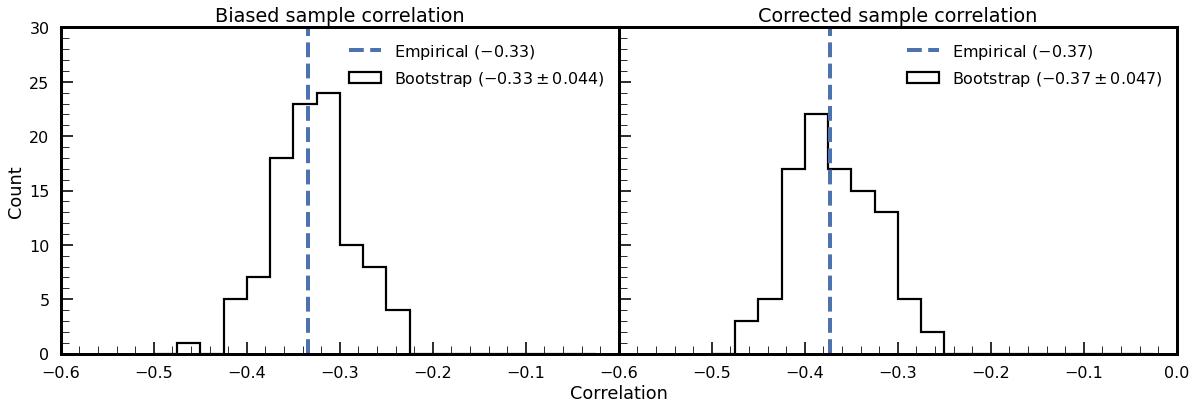

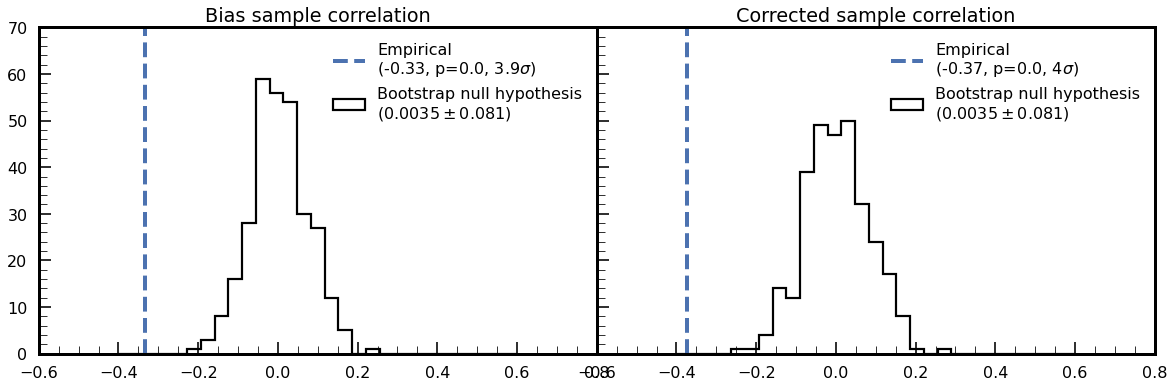

In [8]:
plot_correlation_analysis(age_df, hr_df)
plot_correlation_significance(age_df, hr_df)

## Simulation Results

In [31]:
ncols = len(result_df.columns)
fig, axes = plt.subplots(ncols=ncols, figsize=(12*ncols, 8))
titles = {
    "corr": "Correlation",
    "rcorr": "Spearman Correlation",
    "slope": "Slope",
    "intercept": "Intercept"
}

for i, col in enumerate(result_df.columns):
    ax = axes[i]
    ax.hist(result_df[col], bins=20)
    ax.set_title(f"{titles[col]}\nmean=${result_df[col].mean():.3f}$, sd=${result_df[col].std():.3f}$")
    
plt.tight_layout()

NameError: name 'result_df' is not defined

In [11]:
def get_slope_parameter(x, y):
    """Return the mean and variance of the OLS slope parameter"""
    corr = stats.pearsonr(x, y)[0]
    slope = corr * (np.std(y) / np.std(x))
    
    sigma2 = (np.var(y)**2 + np.var(x)**2)
    slope_var = sigma2 / np.sum((x-np.mean(x))**2)
    
    return slope, slope_var

# x, y = result_df['age'], result_df['hr']
# corr, pvalue_corr = stats.pearsonr(x, y)
# rcorr, pvalue_rcorr = stats.spearmanr(x, y)
# slope, slope_var = get_slope_parameter(x, y)
# intercept = np.mean(y) - slope*np.mean(x)

# plt.figure(figsize=(8,8))
# plt.hist2d(x, y, bins=100, cmap='gray_r')

# xrange = np.linspace(0, 12, 100)
# plt.plot(xrange, slope*xrange + intercept, lw=3)

# plt.annotate(f"Pearson Correlation: {corr:.3f}, p={pvalue_corr:.3f}\nSpearman Correlation: {rcorr:.3f}, p={pvalue_rcorr:.3f}", xy=(0.05, 0.90), xycoords='axes fraction')
# plt.xlabel("Local age [Gyr]")
# plt.ylabel("Hubble residual [mag]")
# plt.xticks(np.arange(0, 14, 2))
# plt.yticks(np.arange(-1, 1.5, 0.5));

# Summary

In [ ]:
summary_df = pd.DataFrame({
                            "bootstrap":  {
                                "slope": result_df["slope"].mean(),
                                "slope_sd": result_df["slope"].std(),
                                "intercept": result_df["intercept"].mean(),
                            },
                            "bootstrap_g": {
                                "slope": result_gaussian_df["slope"].mean(),
                                "slope_sd": result_gaussian_df["slope"].std(),
                                "intercept": result_gaussian_df["intercept"].mean(),
                            },
                            "Rose19": {
                                "slope": -0.1/7,
                                "slope_sd": 0,
                                "intercept": 0.05
                            },
                            "Lee20": {
                                "slope": -0.057,
                                "slope_sd": 0.016,
                                "intercept": 0.22
                            },
                         })

fig = plt.figure(figsize=(24, 8))
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((3, 3), (2, 1), colspan=2)

ax1.errorbar(age_df["age"].groupby('snid').mean(), hr_df["hr"], xerr=age_df["age"].groupby('snid').std(), yerr=hr_df['hr_err'], fmt='ko', lw=0.5, ms=5)
xrange = np.linspace(0, 12, 100)

slope, intercept = summary_df.loc[["slope", "intercept"], "bootstrap"]
ax1.plot(xrange, slope*xrange + intercept, 'k', lw=3, label=f"Bootstrap")

slope, intercept = summary_df.loc[["slope", "intercept"], "bootstrap_g"]
ax1.plot(xrange, slope*xrange + intercept, 'k--', lw=3, label=f"Bootstrap (Gaussian)")

slope, intercept = summary_df.loc[["slope", "intercept"], "Rose19"]
ax1.plot(xrange, slope*xrange + intercept, lw=3, label=f"Rose et al. 2019")

slope, intercept = summary_df.loc[["slope", "intercept"], "Lee20"]
ax1.plot(xrange, slope*xrange + intercept, 'r', lw=3, label=f"Lee et al. 2020")

ax1.legend()
ax1.set_xlabel("Local age [Gyr]")
ax1.set_ylabel("Hubble residual [mag]")

xrange = np.linspace(-0.1, 0, 1000)
# ax2.hist([result_df['slope'], result_gaussian_df['slope']], density=True, bins=15, color=["k", "gray"], label=["Bootstrap", "Bootstrap (Gaussian)"])
ax2.plot(xrange, stats.norm(loc=summary_df.loc["slope", "bootstrap_g"], scale=summary_df.loc["slope_sd", "bootstrap_g"]).pdf(xrange), "k--", label="Bootstrap (Gaussian)")
ax2.plot(xrange, stats.norm(loc=summary_df.loc["slope", "bootstrap"], scale=summary_df.loc["slope_sd", "bootstrap"]).pdf(xrange), "k", label="Bootstrap")
ax2.plot(xrange, stats.norm(loc=summary_df.loc["slope", "Lee20"], scale=summary_df.loc["slope_sd", "Lee20"]).pdf(xrange), c="r", label="Lee et al. 2020")
ax2.axvline(summary_df.loc["slope", "Rose19"], ymax=0.95, label="Rose et al. 2019")

ax2.legend()
ax2.set_xlabel("Slope")
ax2.set_ylabel("Number Density")
ax2.set_xlim(-0.1, 0)

plt_table= pd.plotting.table(ax3, summary_df.T.round(3), loc='center')
plt_table.auto_set_font_size(False)
plt_table.set_fontsize(16)
plt_table.scale(1., 1.8)

ax3.axis("off")
plt.tight_layout()

In [ ]:
(result_df['slope'].mean() - summary_df.loc['slope', 'Lee20']) / np.sqrt(result_df['slope'].std()**2 + summary_df.loc['slope_sd', 'Lee20']**2)

In [ ]:
from itertools import combinations

def get_discrepancy(x, y, xerr, yerr):
    return (x - y) / np.sqrt(xerr**2 + yerr**2)


for cols in list(combinations(summary_df.columns, 2)):
    _df = summary_df.loc[["slope", "slope_sd"], list(cols)].T
    display(_df)
    print(get_discrepancy(_df.iloc[0, 0], _df.iloc[1, 0], _df.iloc[0, 1], _df.iloc[1, 1]))

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
ax1, ax2 = axes

x, y = result_df['age'], result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

ax1.errorbar(age_df["age"].groupby('snid').mean(), hr_df["hr"], xerr=age_df["age"].groupby('snid').std(), yerr=hr_df['hr_err'], fmt='ko', lw=0.5, ms=5)
xrange = np.linspace(0, 12, 100)
ax1.plot(xrange, slope*xrange + intercept, color='k', lw=3, label=f"Bootstrap", zorder=100)

# Incorrect Simulation
x, y = result_gaussian_df['age'], result_gaussian_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

xrange = np.linspace(0, 12, 100)
ax1.plot(xrange, slope*xrange + intercept, color='k', linestyle='dashed', lw=3, label=f"Bootstrap (Gaussian)", zorder=100)


# OLS (no error)
x, y = age_df['age'].groupby('snid').mean(), hr_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)
ax1.plot(xrange, slope*xrange + intercept, c='g', lw=3, label=f"OLS", zorder=100)

# R19 Regression
slope = -0.1/7
intercept = 0.05
ax1.plot(xrange, slope*xrange + intercept, lw=3, label=f"Rose et al. 2019 (approx)", zorder=100)

# L20 Regression
slope = -0.057
intercept = 0.22
xrange = np.linspace(0, 12, 100)
ax1.plot(xrange, slope*xrange + intercept, c='r', lw=3, label=f"Lee et al. 2020 (approx)", zorder=100)

ax1.set_xlabel("Local age [Gyr]")
ax1.set_ylabel("Hubble residual [mag]")
ax1.set_xlim(0, 12)
ax1.set_xticks(np.arange(0, 14, 2))
ax1.set_yticks(np.arange(-0.8, 1, 0.2))
ax1.legend(loc='upper right')

plt.tight_layout()
plt.savefig(FIGURESPATH/"campbell_correlation_summary.pdf")

,slope,intercept
OLS,-0.020,0.069
ODR,-0.055,0.250
Rose et al. (2019),-0.014,0.050
Lee et al. (2020),-0.057,0.220
Proposed Model,-0.030,0.081


\begin{tabular}{lrr}
\toprule
{} &  slope &  intercept \\
\midrule
OLS                & -0.020 &      0.069 \\
ODR                & -0.055 &      0.250 \\
Rose et al. (2019) & -0.014 &      0.050 \\
Lee et al. (2020)  & -0.057 &      0.220 \\
Proposed Model     & -0.030 &      0.081 \\
\bottomrule
\end{tabular}



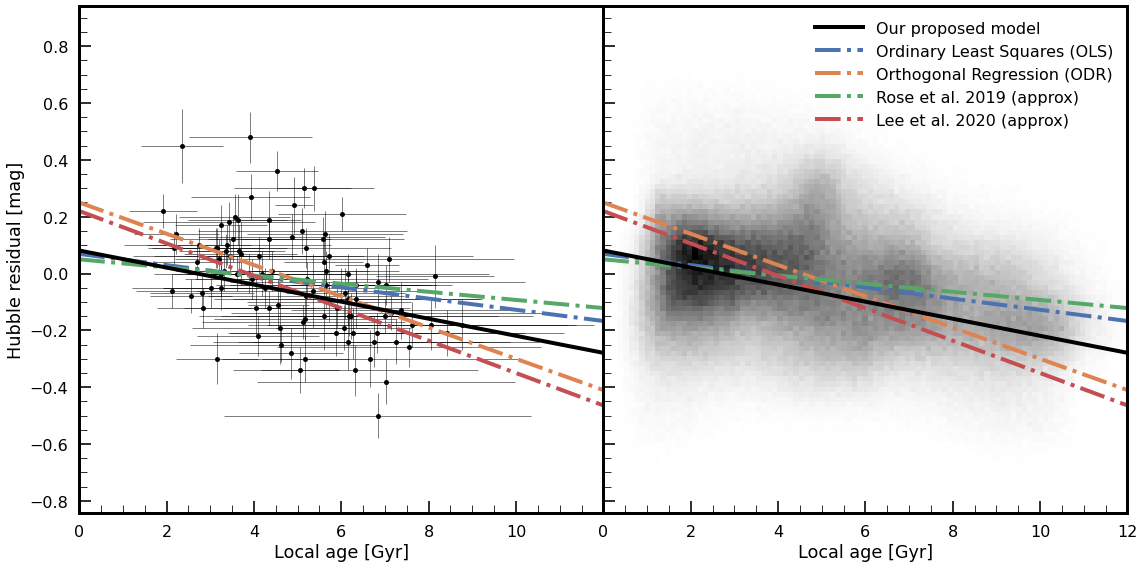

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8), sharey=True, squeeze=True)
ax1, ax2 = axes

summary = {}

# Plot Data
ax1.errorbar(age_df["age"].groupby('snid').mean(), hr_df["hr"], xerr=age_df["age"].groupby('snid').std(), yerr=hr_df['hr_err'], fmt='ko', lw=0.5, ms=5, zorder=0)

## Bootstrap Sample
x, y = result_df['age'], result_df['hr']
ax2.hist2d(x, y, bins=100, cmap='gray_r', zorder=0)

# Plot Regressions
xrange = np.linspace(0, 12, 100)

## OLS Bootstrap Regression
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)
[ax.plot(xrange, slope*xrange + intercept, linestyle='dashdot', label=f"Ordinary Least Squares (OLS)") for ax in axes]
summary["OLS"] = {"slope": slope, "intercept": intercept}

## ODR MCMC Regression
slope = -0.055
intercept =  0.25
[ax.plot(xrange, slope*xrange + intercept, linestyle='dashdot', label=f"Orthogonal Regression (ODR)") for ax in axes]
summary["ODR"] = {"slope": slope, "intercept": intercept}

# Rose19 Regression
slope = -0.1/7
intercept = 0.05
[ax.plot(xrange, slope*xrange + intercept, linestyle='dashdot', label=f"Rose et al. 2019 (approx)") for ax in axes]
summary["Rose et al. (2019)"] = {"slope": slope, "intercept": intercept}


## LINMIX Lee20 
slope = -0.057
intercept =  0.22
[ax.plot(xrange, slope*xrange + intercept, linestyle='dashdot', label=f"Lee et al. 2020 (approx)") for ax in axes]
summary["Lee et al. (2020)"] = {"slope": slope, "intercept": intercept}

## Ours
slope = -0.03
intercept =  0.081
[ax.plot(xrange, slope*xrange + intercept, color='k', label=f"Our proposed model") for ax in axes]
summary["Proposed Model"] = {"slope": slope, "intercept": intercept}

for ax in axes:
    ax.set_xlabel("Local age [Gyr]")
    ax.set_xlim(0, 12)
    ax.set_xticks(np.arange(0, 14, 2))
    
    ax.set_yticks(np.arange(-0.8, 1, 0.2))

ax1.xaxis.get_major_ticks() [-1].label1.set_visible(False)
ax1.set_ylabel("Hubble residual [mag]")

handles, labels = ax2.get_legend_handles_labels()
order = [4, 0, 1, 2, 3]
labels, handles = np.array(labels)[order].tolist(), np.array(handles)[order].tolist()
ax2.legend(handles, labels, loc='upper right', handlelength=3)
    
plt.tight_layout()
fig.subplots_adjust(wspace=0)
plt.savefig(FIGURESPATH/"summary_line_fit.pdf", facecolor='white', dpi=300)

summary_df = pd.DataFrame(summary).round(3).T
display(summary_df)
print(summary_df.to_latex())

# Supplementary

## Downsample Analysis

In [5]:
results = []
for snid in tqdm(snids):
    all_global_age_df = pd.read_table(DATAPATH/f"mcmc_chains/campbellG/SN{snid}_campbellG_chain.tsv", skiprows=[1], index_col=False, usecols=[7], sep="\t")
    ks, pvalue = stats.ks_2samp(age_global_df.loc[snid, 'age'], all_global_age_df['age'])
    result = {
        "snid": snid,
        "ks": ks,
        "pvalue": pvalue 
    }
    results.append(result)
    
ks_df = pd.DataFrame(results).set_index('snid').sort_values('pvalue', ascending=True)
ks_df

100%|██████████| 102/102 [02:00<00:00,  1.19s/it]


,ks,pvalue
snid,,
3592,0.005907,0.071580
19953,0.005665,0.093449
5890,0.005658,0.094203
14437,0.005371,0.127344
20084,0.005310,0.135527
...,...,...
19155,0.002041,0.988491
1032,0.001970,0.992459
12860,0.001930,0.994156


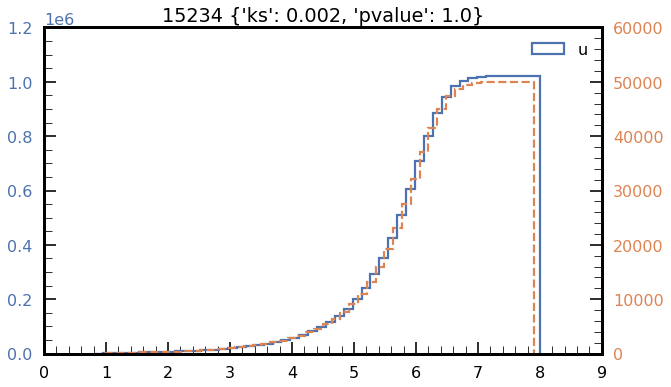

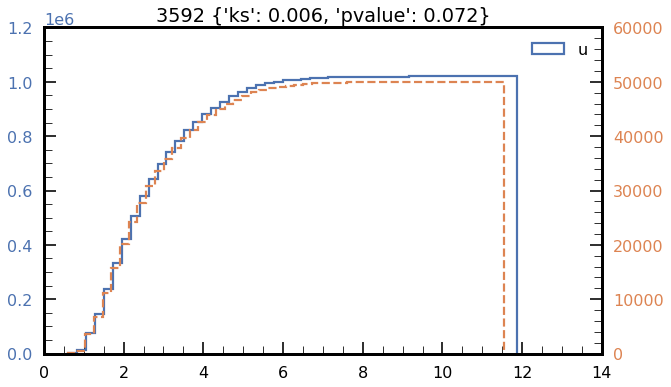

In [7]:
for snid in [ks_df.index[-1], ks_df.index[0]]:
    all_global_age_df = pd.read_table(DATAPATH/f"mcmc_chains/campbellG/SN{snid}_campbellG_chain.tsv", skiprows=[1], index_col=False, usecols=[7], sep="\t")

    fig, ax1 = plt.subplots()
    
    color = "#4c72b0"
    ax1.hist(all_global_age_df['age'], bins=50, color=color, histtype='step', cumulative=True, label='all')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend("upper left")
    
    color = "#dd8452"
    ax2 = ax1.twinx()
    ax2.hist(age_global_df.loc[snid, 'age'], bins=50, color=color, linestyle="--", histtype='step', cumulative=True, label='downsample')
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.legend("upper right")

    
    ax1.set_title(f"{snid} {ks_df.loc[snid, :].round(3).to_dict()}")

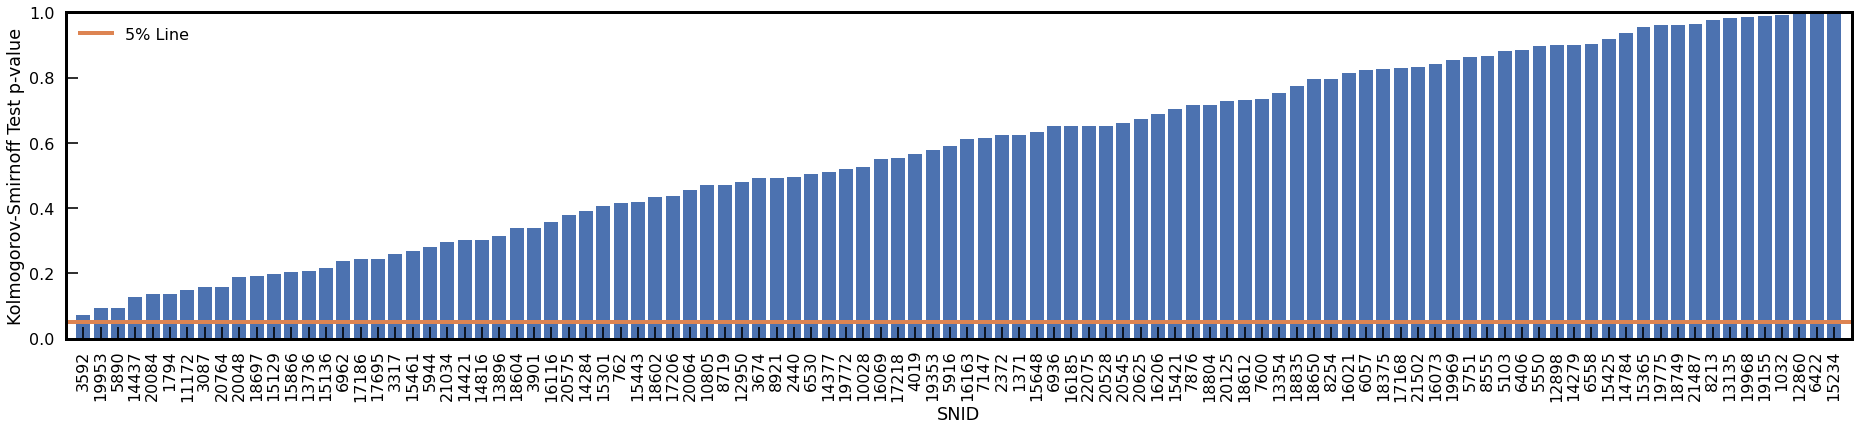

In [8]:
plt.figure(figsize=(32, 6))
plt.bar(ks_df.index.astype(str), ks_df.pvalue)
plt.axhline(0.05, color='#dd8452', label="5% Line")

plt.xticks(rotation=90)
plt.minorticks_off()
plt.xlim(-1, len(ks_df))
plt.ylim(0, 1)

plt.xlabel("SNID")
plt.ylabel("Kolmogorov-Smirnoff Test p-value")
plt.legend();

## Statistical Simulation - Sampling Age and Hubble Residual
To determine correlation, statistical simulation by sampling the age and HR simulation joint distribution provides a estimate of the true correlation without the need for model-fitting. For each SNe, the variablility of age and HR is accounted for with large enough samples of each distribution.

For each of the $N_\text{snid}$ SNe,

* 10000 samples without replacement of HR assuming Gaussian distribution given it respective parameters.
* 10000 samples without replacement of Age given the MCMC-derived posterior sample with no fitting of its distribution.

The total sample size is $N_\text{snid} \times 10000$

In [9]:
def simulate(age_df, hr_df, sample_size=10000):
    sample_dfs = []
    for i, snid in enumerate(snids):
        print(f"{i}/{len(snids)}", end="\r")
        # Age ~ MCMC marginalized posterior of given SNID
        snid_age_sample = RNG.choice(age_df.loc[snid, "age"], size=sample_size)

        # HR ~ Normal(hr[snid], hr_err[snid])
        snid_hr_dist = stats.norm(loc=hr_df.loc[snid, "hr"], scale=hr_df.loc[snid, "hr_err"])
        snid_hr_dist.random_state = RNG
        snid_hr_sample = snid_hr_dist.rvs(size=sample_size)

        sample_df = pd.DataFrame({
            "age": snid_age_sample,
            "hr": snid_hr_sample
        }, index=[snid]*sample_size)
        sample_dfs.append(sample_df)

    print(f"{i+1}/{len(snids)}", end="\r")
    result_df = pd.concat(sample_dfs)
    result_df.index.name = "snid"
    result_df.to_csv(RESULTSPATH/"campbell_hr_age_simulation.csv")

def get_simulation():
    return pd.read_csv(RESULTSPATH/"campbell_hr_age_simulation.csv")

# simulate(age_df, hr_df)
result_df = get_simulation()

In [35]:
# def simulate(age_df, hr_df, reps=1000):
#     assert len(age_df.index.unique()) == len(hr_df)
#     sample_size = len(hr_df)
    
#     corrs = []
#     rcorrs = []
#     slopes = []
#     intercepts = []
#     for i in range(reps):
#         xsample = age_df.groupby('snid').sample(1)['age']
        
#         ydist = stats.norm(loc=hr_df['hr'], scale=hr_df['hr_err'])
#         ysample = ydist.rvs(sample_size)
        
#         corr = stats.pearsonr(xsample, ysample)[0]
#         corrs.append(corr)
        
#         rcorr = stats.spearmanr(xsample, ysample)[0]
#         rcorrs.append(rcorr)

#         slope = corr * (np.std(ysample) / np.std(xsample))
#         slopes.append(slope)
        
#         intercept = np.mean(ysample) - slope*np.mean(xsample)
#         intercepts.append(intercept)
        
#         if (i+1) % 100 == 0: 
#             print(f"{i+1}/{reps}", end="\r")
    
    
#     result_df = pd.DataFrame({"corr": corrs, "rcorr": rcorrs, "slope": slopes, "intercept": intercept})
#     result_df.to_csv(RESULTSPATH/"campbell_hr_age_simulation.csv", index=False)

# def get_simulation():
#     return pd.read_csv(RESULTSPATH/"campbell_hr_age_simulation.csv")

# # simulate(age_df, hr_df)
# result_df = get_simulation()

## Gaussian Mixture Model

In [5]:
from models.gaussian_mixture import GaussianMixture

def plot_gmm(age_df, gmm):
    # DATA
    results = {snid: result for snid, result in zip(snids, gmm.get_results())}
    
    # PLOT
    nrows, ncols = 4, 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*4), sharex=True)
    axs = axs.reshape(nrows, ncols)

    xrange = np.linspace(0, 15, 60)
    bins = xrange[::2]
    random_snids = np.random.choice(snids, size=nrows*ncols)
    # random_snids = [1794, 21502, 6936, 3674]
    for i in range(nrows*ncols):
        if i >= len(random_snids):
            break
        else:    
            snid = random_snids[i]

        ax = axs[i//ncols, i%ncols]
        hr_row = hr_df.loc[snid, :]

        ax.hist(age_df.loc[snid, :], bins, density=True, color='k', histtype="step")

        result = results[snid]
        probs = np.exp(result.score_samples(xrange.reshape(-1, 1)))
        ax.plot(xrange, probs)

        ax.set_title(f"SNID {snid} \n", loc="left", x=-1, y=0.5, va="center")
        ax.set_ylabel(f"${hr_row['hr']:.2f}\pm{hr_row['hr_err']:.2f}$\n[mag]", rotation='horizontal', labelpad=80)
        ax.yaxis.set_tick_params(which='both', left=False, labelleft=False)

    fig.subplots_adjust(hspace=0)
    plt.xlabel("Age [Gyr]")
    plt.savefig(f"paper/figures/gmm_age_posterior_fit_{gmm.name}.png", transparent=False)


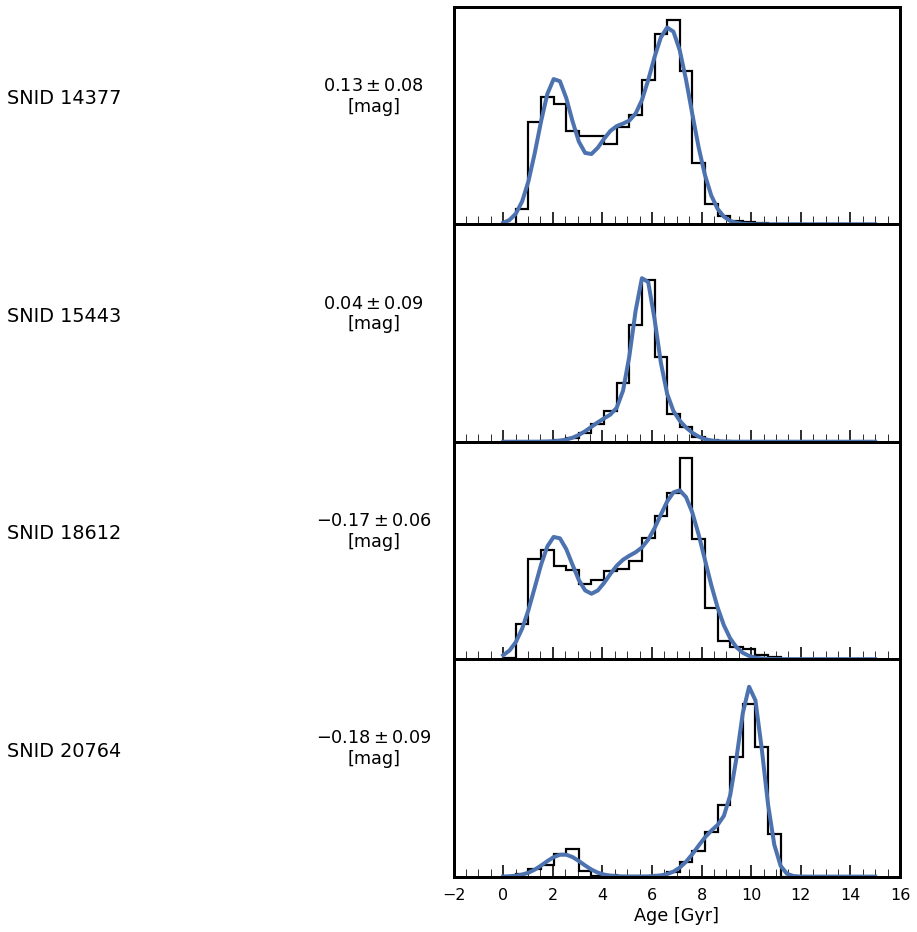

In [8]:
gmm = GaussianMixture("local")
plot_gmm(age_df, gmm)

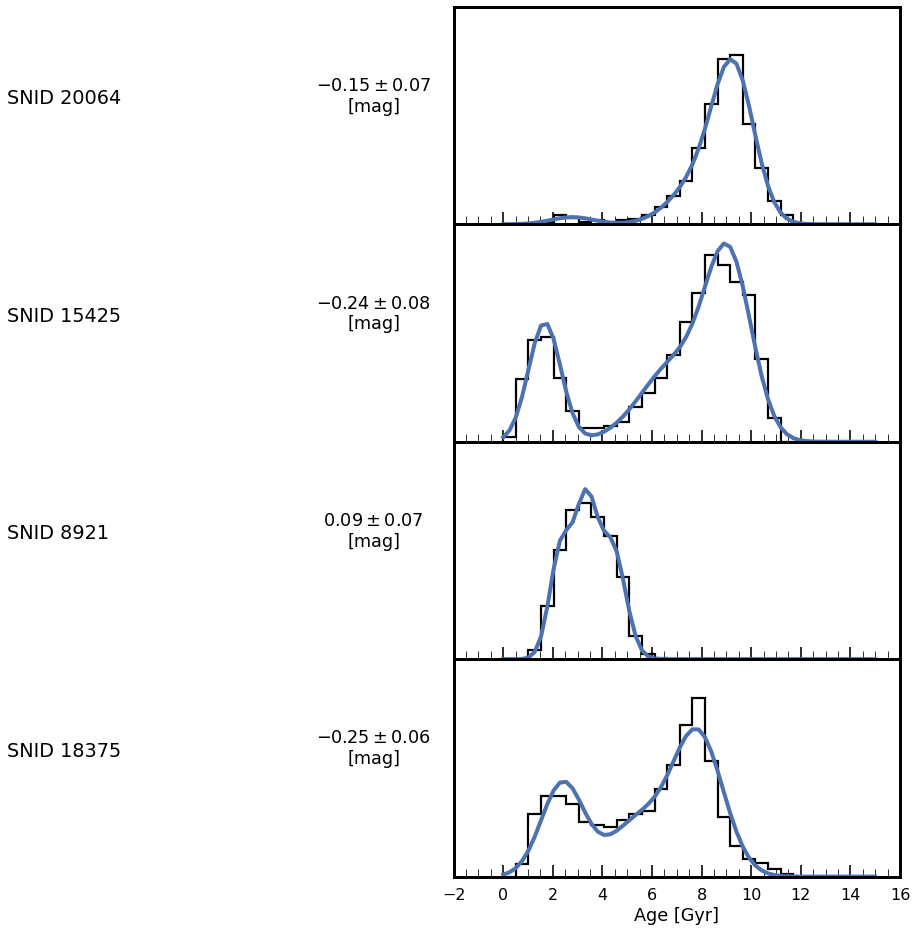

In [9]:
gmm = GaussianMixture("global")
plot_gmm(age_global_df, gmm)

## Correlation Analysis with All Gaussian Errors

Attempting to incorrectly do correlation analysis that L20 did which changes the previous correlation analysis by the assumption of the Age distribution:

* 10000 samples without replacement of Age assumed to be <span style="color: red">Gaussian parameters from the MCMC-derived posterior mean and SD</span>.

In [ ]:
def simulate_with_gaussian(age_df, hr_df, reps=1000):
    assert len(age_df.index.unique()) == len(hr_df)
    sample_size = len(hr_df)
    
    corrs = []
    rcorrs = []
    slopes = []
    intercepts = []
    for i in range(reps):
        xdist = stats.norm(loc=age_df['age'].groupby('snid').mean(), scale=age_df['age'].groupby('snid').std())
        xsample = xdist.rvs(sample_size)
        
        ydist = stats.norm(loc=hr_df['hr'], scale=hr_df['hr_err'])
        ysample = ydist.rvs(sample_size)
        
        corr = stats.pearsonr(xsample, ysample)[0]
        corrs.append(corr)
        
        rcorr = stats.spearmanr(xsample, ysample)[0]
        rcorrs.append(rcorr)

        slope = corr * (np.std(ysample) / np.std(xsample))
        slopes.append(slope)
        
        intercept = np.mean(ysample) - slope*np.mean(xsample)
        intercepts.append(intercept)
        
        if (i+1) % 100 == 0: 
            print(f"{i+1}/{reps}", end="\r")
            
    result_df = pd.DataFrame({"corr": corrs, "rcorr": rcorrs, "slope": slopes, "intercept": intercept})
    result_df.to_csv(RESULTSPATH/"campbell_hr_age_gaussian_simulation.csv", index=False)

def get_simulation_with_gaussian():
    return pd.read_csv(RESULTSPATH/"campbell_hr_age_gaussian_simulation.csv")

# simulate_with_gaussian(age_df, hr_df)
result_gaussian_df = get_simulation_with_gaussian()

In [ ]:
ncols = len(result_gaussian_df.columns)
fig, axes = plt.subplots(ncols=ncols, figsize=(12*ncols, 8))
titles = {
    "corr": "Correlation",
    "rcorr": "Spearman Correlation",
    "slope": "Slope",
    "intercept": "Intercept"
}

for i, col in enumerate(result_gaussian_df.columns):
    ax = axes[i]
    ax.hist(result_gaussian_df[col], bins=20)
    ax.set_title(f"{titles[col]}\nmean=${result_gaussian_df[col].mean():.3f}$, sd=${result_gaussian_df[col].std():.3f}$")
    
plt.tight_layout()

In [ ]:
# x, y = result_gaussian_df['age'], result_gaussian_df['hr']
# corr, pvalue_corr = stats.pearsonr(x, y)
# rcorr, pvalue_rcorr = stats.spearmanr(x, y)
# slope = corr * (np.std(y) / np.std(x))
# intercept = np.mean(y) - slope*np.mean(x)

# plt.figure(figsize=(8,8))
# cut = (x > 0) & (x < 12)
# plt.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')

# xrange = np.linspace(0, 12, 100)
# plt.plot(xrange, slope*xrange + intercept, lw=3)

# plt.annotate(f"Pearson Correlation: {corr:.3f}, p={pvalue_corr:.3f}\nSpearman Correlation: {rcorr:.3f}, p={pvalue_rcorr:.3f}", xy=(0.05, 0.90), xycoords='axes fraction')
# plt.xlabel("Local age [Gyr]")
# plt.ylabel("Hubble residual [mag]")
# plt.xticks(np.arange(0, 14, 2))
# plt.yticks(np.arange(-1, 1.5, 0.5))

In [ ]:
# plt.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')
# plt.errorbar(
#     age_df.groupby('snid').mean()["age"], 
#     hr_df.groupby('snid').mean()["hr"], 
#     xerr=age_df.groupby('snid').std()["age"], 
#     yerr=hr_df["hr"].groupby('snid').apply(lambda s: np.sqrt(np.sum(s**2))), 
#     fmt='.', lw=1)

In [ ]:
def correlation_test(x, y, corr_func=stats.pearsonr, sample_size=100, repetition=1000):
    """Test the significance of the correlation with null hypothesis of zero correlation"""
    corr = corr_func(x, y)[0] # We will ignore 2nd arg which is the p-value
    
    corr_samples = []
    for i in range(repetition):
        x_sample = np.random.choice(x, size=sample_size)
        y_sample = np.random.choice(y, size=sample_size)
        corr_sample = corr_func(x_sample, y_sample)[0]
        corr_samples.append(corr_sample)
    
    pvalue = np.mean(corr_samples <= corr)
    return corr, pvalue, corr_samples

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax = axes[0]
_corr, _pvalue, _corr_samples = correlation_test(result_df['age'], result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ distribution")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"MCMC Posterior Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.legend(loc='upper left')

ax = axes[1]
_corr, _pvalue, _corr_samples = correlation_test(result_gaussian_df['age'], result_gaussian_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ distribution")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"Gaussian Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.legend(loc='upper left')
